In [ ]:
!pip install lightgbm xgboost catboost optuna


In [ ]:
!pip install catboost

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
sns.set(style="whitegrid")


# Dataset Loading

In [ ]:

file_path = '/content/Rotten_Tomatoes_Movies3.xls'
data = pd.read_excel(file_path)


# Dataset Inspection

In [ ]:

print("First 5 rows of the dataset:")
data.head()



First 5 rows of the dataset:


,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [ ]:
print("\nDataset Information:")
print(data.info())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  1663

In [ ]:

print("\nSummary Statistics:")
print(data.describe())




Summary Statistics:
                    in_theaters_date              on_streaming_date  \
count                          15823                          16636   
mean   1999-10-24 22:10:52.973519488  2008-08-13 13:35:49.266650624   
min              1914-06-01 00:00:00            1935-06-06 00:00:00   
25%              1993-03-29 00:00:00            2003-01-28 00:00:00   
50%              2006-08-04 00:00:00            2008-04-08 00:00:00   
75%              2013-06-28 00:00:00            2014-05-12 00:00:00   
max              2019-12-07 00:00:00            2019-11-01 00:00:00   
std                              NaN                            NaN   

       runtime_in_minutes  tomatometer_rating  tomatometer_count  \
count        16483.000000        16638.000000       16638.000000   
mean           102.391494           60.466522          56.607104   
min              1.000000            0.000000           5.000000   
25%             90.000000           38.000000          12.000000   

In [ ]:
print("\nNull Values in Each Column:")
print(data.isnull().sum())


Null Values in Each Column:
movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64


# Visualizing missing values before handling

<ipython-input-10-ba0f4195e970>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")


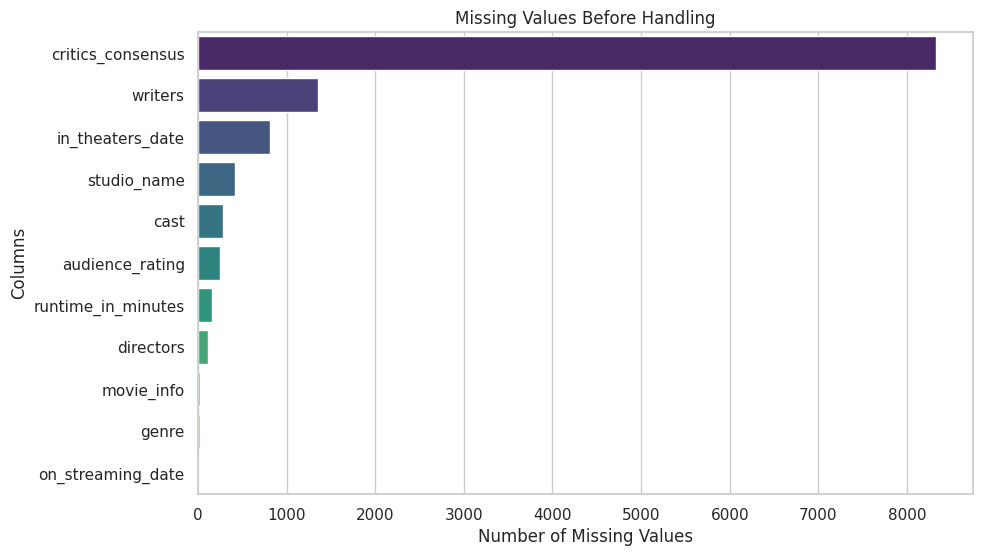

In [ ]:

plt.figure(figsize=(10, 6))
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")
plt.title("Missing Values Before Handling")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.show()

# Visualizing Distribution of Categories Based on 'tomatometer_rating'

<ipython-input-11-1d4ba6b4dc53>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=rating_categories, palette="viridis", order=categories)


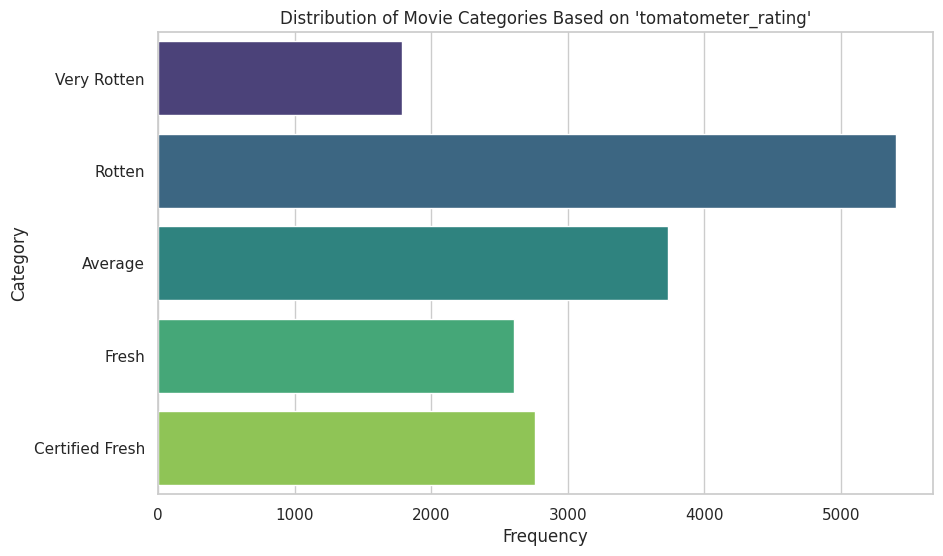

In [ ]:

if 'tomatometer_rating' in data.columns:
    plt.figure(figsize=(10, 6))

    categories = ['Very Rotten', 'Rotten', 'Average', 'Fresh', 'Certified Fresh']
    bins = [0, 20, 60, 80, 90, 100]
    rating_categories = pd.cut(data['tomatometer_rating'], bins=bins, labels=categories, right=True)

    sns.countplot(y=rating_categories, palette="viridis", order=categories)
    plt.title("Distribution of Movie Categories Based on 'tomatometer_rating'")
    plt.xlabel("Frequency")
    plt.ylabel("Category")
    plt.show()


#  Handling Missing Values Using IterativeImputer on numerical columns

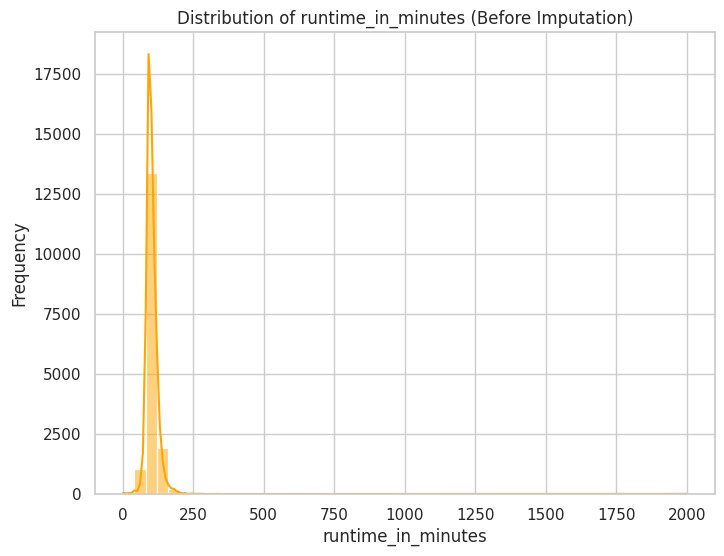

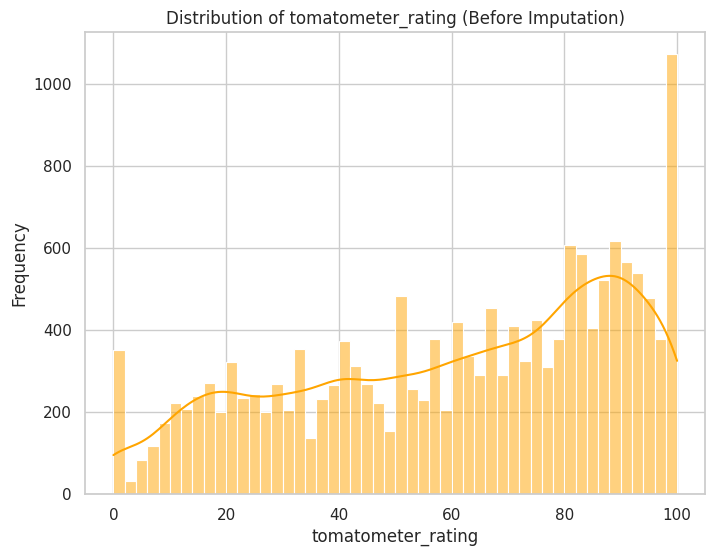

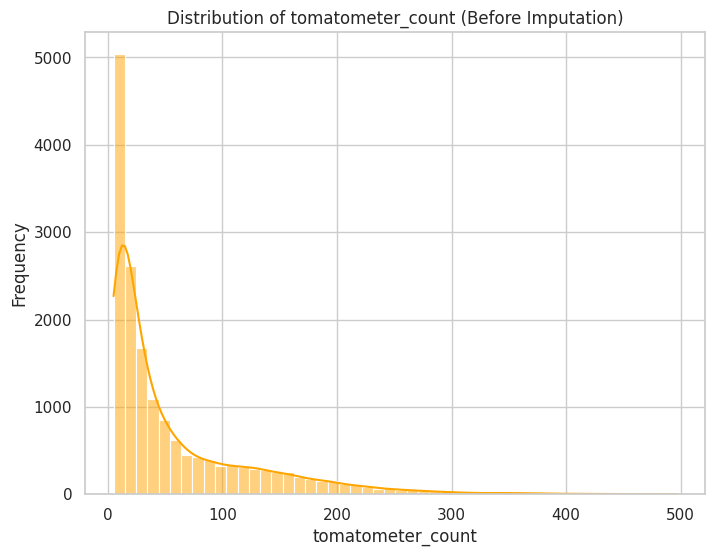

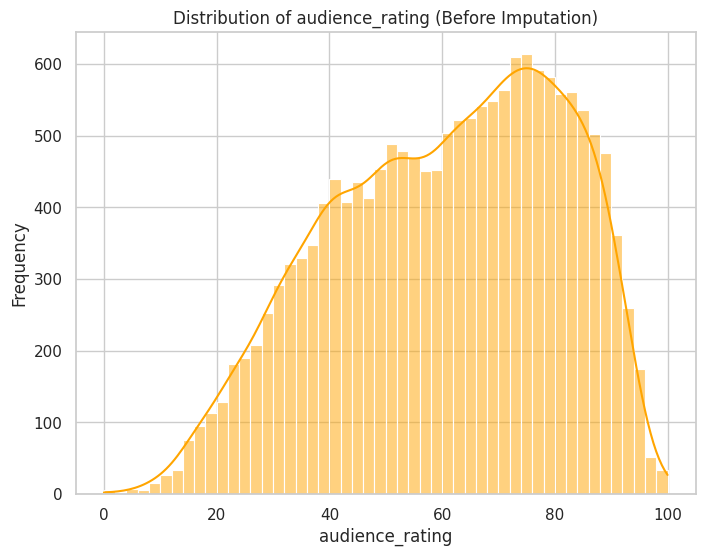

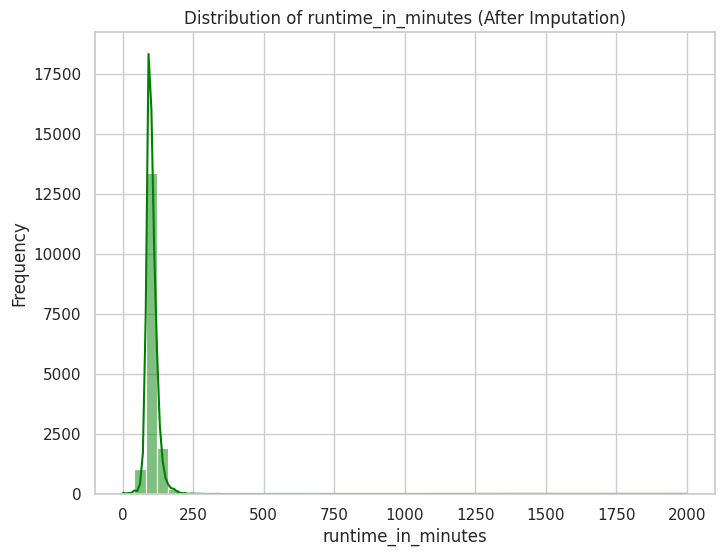

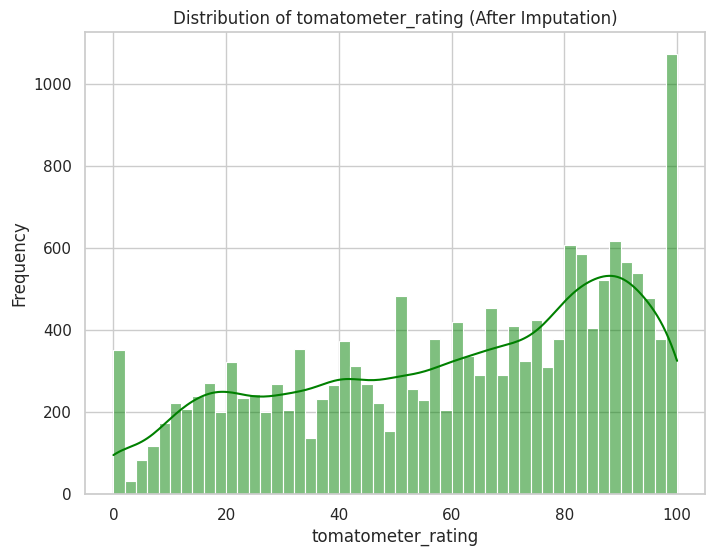

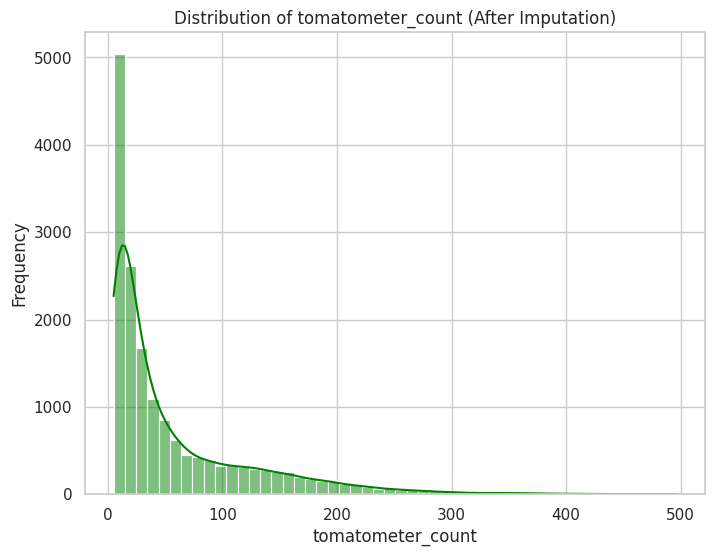

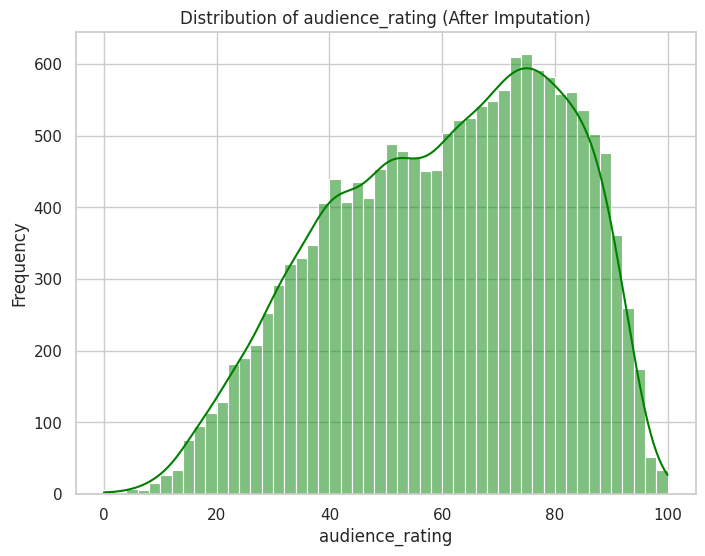

In [ ]:
# Handle missing numerical columns
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
imputer = IterativeImputer(random_state=42)
data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[col], bins=50, kde=True, color='orange')
    plt.title(f"Distribution of {col} (Before Imputation)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[col], bins=50, kde=True, color='green')
    plt.title(f"Distribution of {col} (After Imputation)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

Handling Missing Values in Categorical Columns


In [ ]:
categorical_columns = data.select_dtypes(include='object').columns.tolist()
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])


In [ ]:
print("\nNull Values After Imputation:")
print(data.isnull().sum())


Null Values After Imputation:
movie_title             0
movie_info              0
critics_consensus       0
rating                  0
genre                   0
directors               0
writers                 0
cast                    0
in_theaters_date      815
on_streaming_date       2
runtime_in_minutes      0
studio_name             0
tomatometer_status      0
tomatometer_rating      0
tomatometer_count       0
audience_rating         0
dtype: int64



Handling Outliers in 'runtime_in_minutes'and Visualize runtime before capping

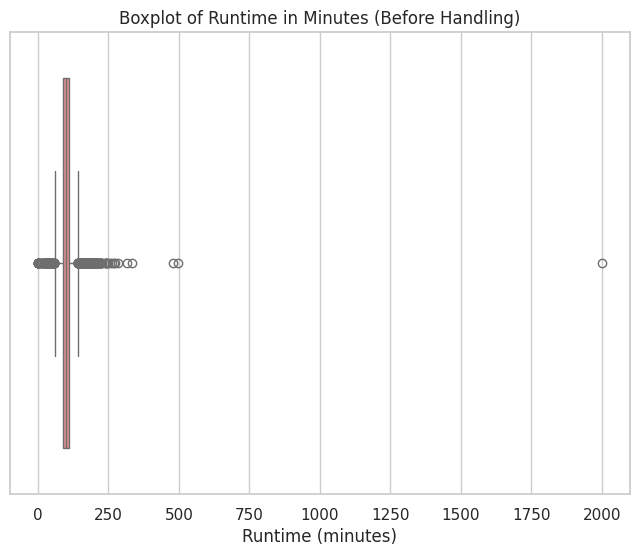

In [ ]:

plt.figure(figsize=(8, 6))
sns.boxplot(x=data['runtime_in_minutes'], color='lightcoral')
plt.title("Boxplot of Runtime in Minutes (Before Handling)")
plt.xlabel("Runtime (minutes)")
plt.show()

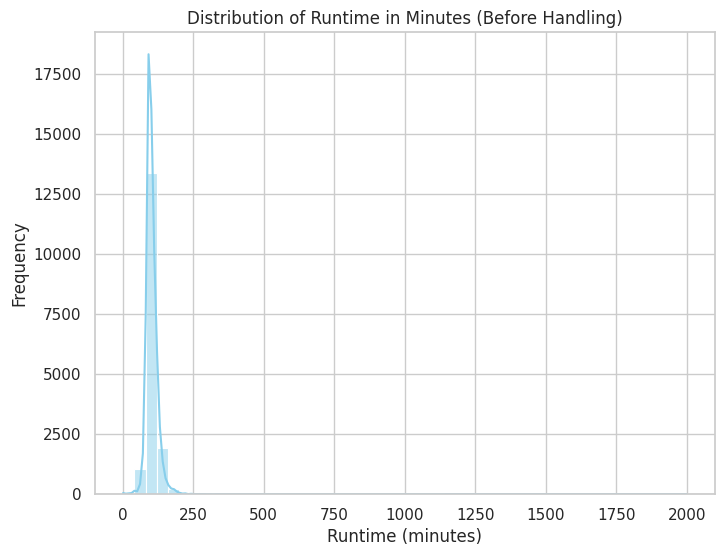

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['runtime_in_minutes'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Runtime in Minutes (Before Handling)")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.show()

In [ ]:

data['runtime_in_minutes'] = np.clip(data['runtime_in_minutes'], a_min=1, a_max=300)


 Visualize runtime after capping

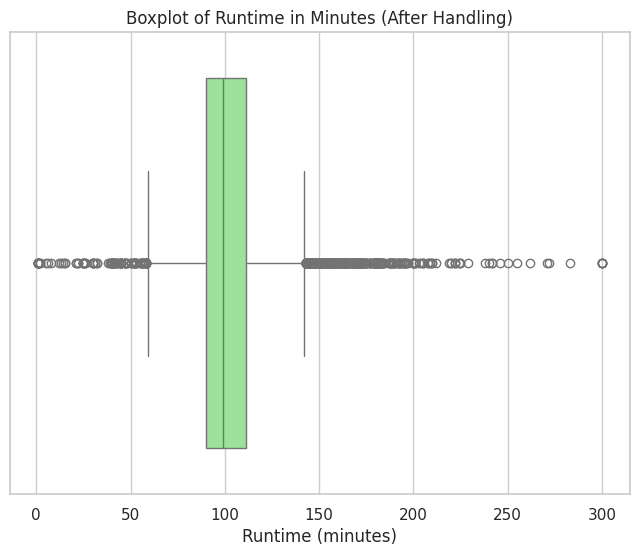

In [ ]:

plt.figure(figsize=(8, 6))
sns.boxplot(x=data['runtime_in_minutes'], color='lightgreen')
plt.title("Boxplot of Runtime in Minutes (After Handling)")
plt.xlabel("Runtime (minutes)")
plt.show()

<ipython-input-19-0a308c0133b4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values_after.values, y=missing_values_after.index, palette="viridis")


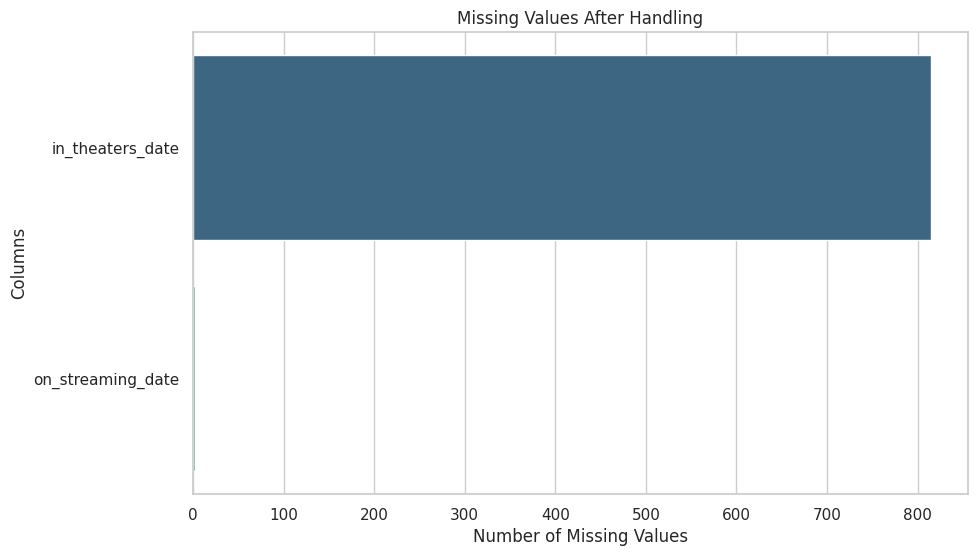

Missing values after handling:
 movie_title             0
movie_info              0
critics_consensus       0
rating                  0
genre                   0
directors               0
writers                 0
cast                    0
in_theaters_date      815
on_streaming_date       2
runtime_in_minutes      0
studio_name             0
tomatometer_status      0
tomatometer_rating      0
tomatometer_count       0
audience_rating         0
dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
missing_values_after = data.isnull().sum().sort_values(ascending=False)
missing_values_after = missing_values_after[missing_values_after > 0]
sns.barplot(x=missing_values_after.values, y=missing_values_after.index, palette="viridis")
plt.title("Missing Values After Handling")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.show()

print("Missing values after handling:\n", data.isnull().sum())


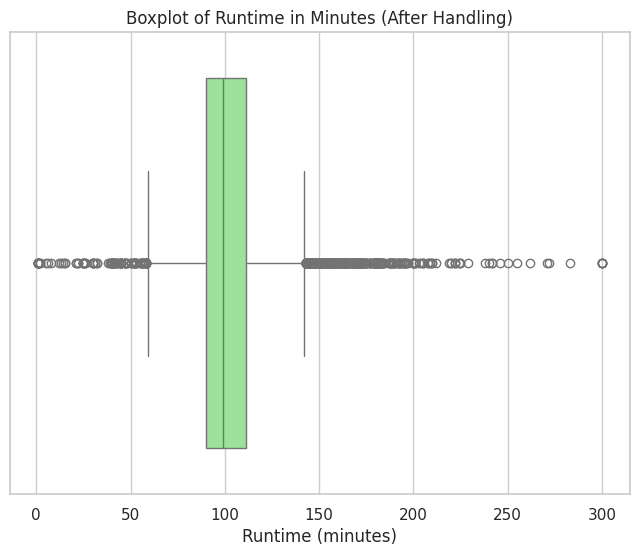

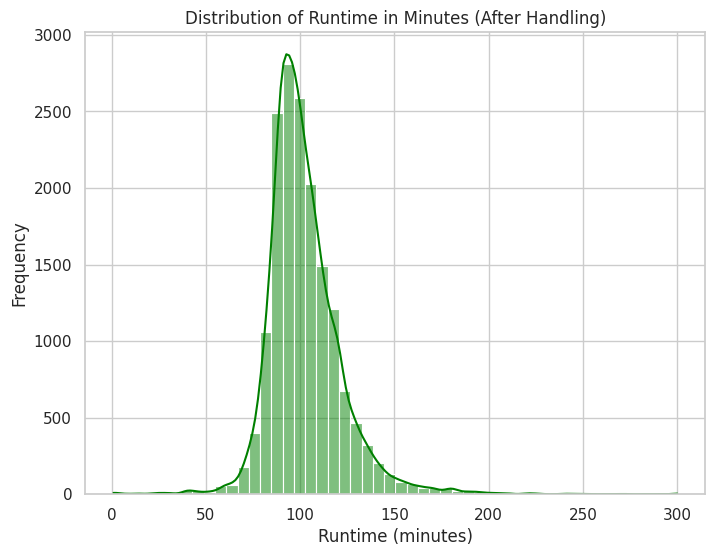

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['runtime_in_minutes'], color='lightgreen')
plt.title("Boxplot of Runtime in Minutes (After Handling)")
plt.xlabel("Runtime (minutes)")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data['runtime_in_minutes'], bins=50, kde=True, color='green')
plt.title("Distribution of Runtime in Minutes (After Handling)")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
print(f"Number of duplicate rows before removal: {data.duplicated().sum()}")
data = data.drop_duplicates()
print(f"Number of duplicate rows after removal: {data.duplicated().sum()}")


Number of duplicate rows before removal: 1
Number of duplicate rows after removal: 0


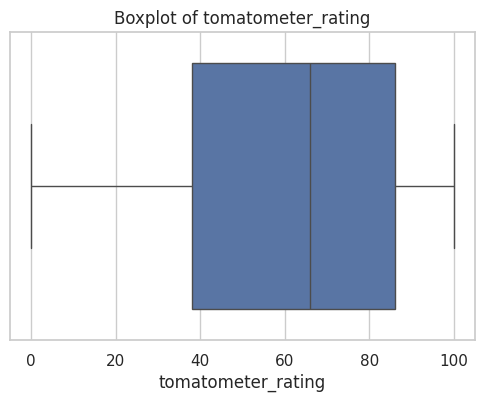

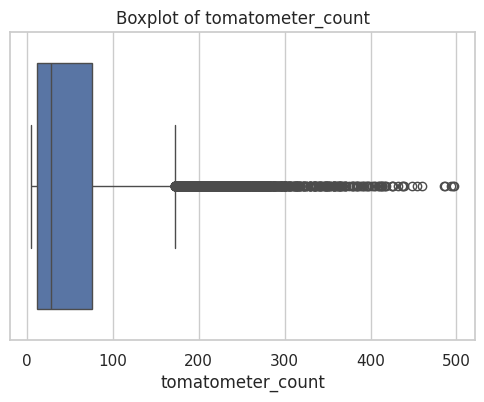

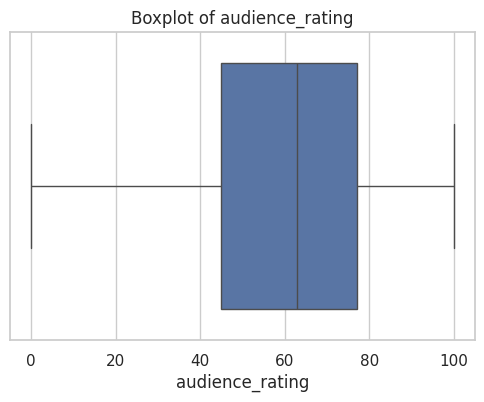

In [ ]:
numerical_columns = ['tomatometer_rating', 'tomatometer_count', 'audience_rating']
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


In [ ]:
print("Unique genres:", data['genre'].unique())


Unique genres: ['Action & Adventure, Comedy, Drama, Science Fiction & Fantasy' 'Comedy'
 'Comedy, Romance' ... 'Art House & International, Romance'
 'Action & Adventure, Drama, Horror, Kids & Family, Mystery & Suspense'
 'Animation, Drama, Romance']


In [ ]:

data = data.dropna(subset=['audience_rating'])

In [ ]:

runtime_median = data['runtime_in_minutes'].median()
data['runtime_in_minutes'] = data['runtime_in_minutes'].fillna(runtime_median)



In [ ]:
data['directors'] = data['directors'].fillna('Unknown Director')
data['writers'] = data['writers'].fillna('Unknown Writer')
data['cast'] = data['cast'].fillna('Unknown Cast')
data['studio_name'] = data['studio_name'].fillna('Unknown Studio')


In [ ]:
data['in_theaters_date'] = pd.to_datetime(data['in_theaters_date'], errors='coerce')
data['on_streaming_date'] = pd.to_datetime(data['on_streaming_date'], errors='coerce')


In [ ]:
# Step 2: Handle Missing Values in Datetime Columns
datetime_columns = ['in_theaters_date', 'on_streaming_date']
for col in datetime_columns:
    if col in data.columns:
        median_date = data[col].dropna().median()  # Median date for imputation
        data[col].fillna(median_date, inplace=True)

# Verify Null Values in Datetime Columns
print("\nNull Values in Datetime Columns After Handling:")
print(data[datetime_columns].isnull().sum())



Null Values in Datetime Columns After Handling:
in_theaters_date     0
on_streaming_date    0
dtype: int64


<ipython-input-30-fa1a1c32d0f5>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_date, inplace=True)
<ipython-input-30-fa1a1c32d0f5>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
print("\nMissing Values After Handling:")
print(data.isnull().sum())


Missing Values After Handling:
movie_title           0
movie_info            0
critics_consensus     0
rating                0
genre                 0
directors             0
writers               0
cast                  0
in_theaters_date      0
on_streaming_date     0
runtime_in_minutes    0
studio_name           0
tomatometer_status    0
tomatometer_rating    0
tomatometer_count     0
audience_rating       0
dtype: int64


# Feature Engineering




New Features Added:
   time_to_stream runtime_category  rating_weighted  release_month  \
0             137           Medium           7056.0              2   
1             172           Medium          12040.0              4   
2            6536           Medium           1496.0             10   
3           16033           Medium           5100.0              4   
4           18036             Long           2403.0              1   

   release_year  movie_info_length directors_simplified  
0          2010                 24               Others  
1          2010                126               Others  
2          1979                133        Blake Edwards  
3          1957                341         Sidney Lumet  
4          1954                 97               Others  


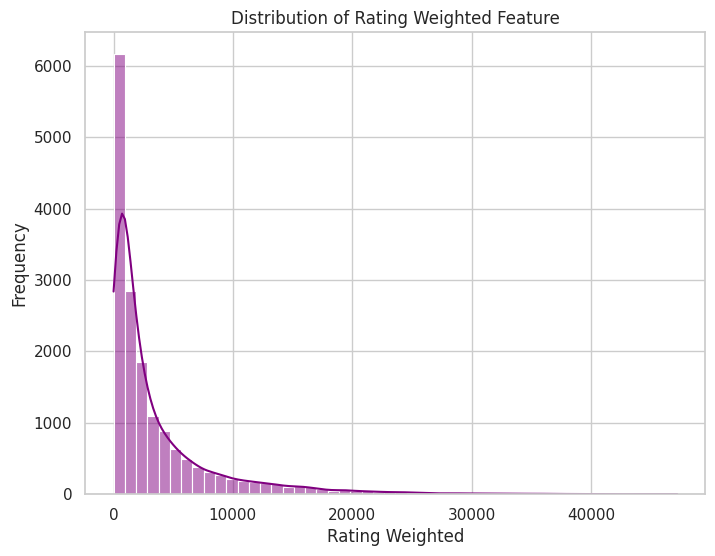

<ipython-input-32-534c00f7dc1b>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['runtime_category'], palette="viridis")


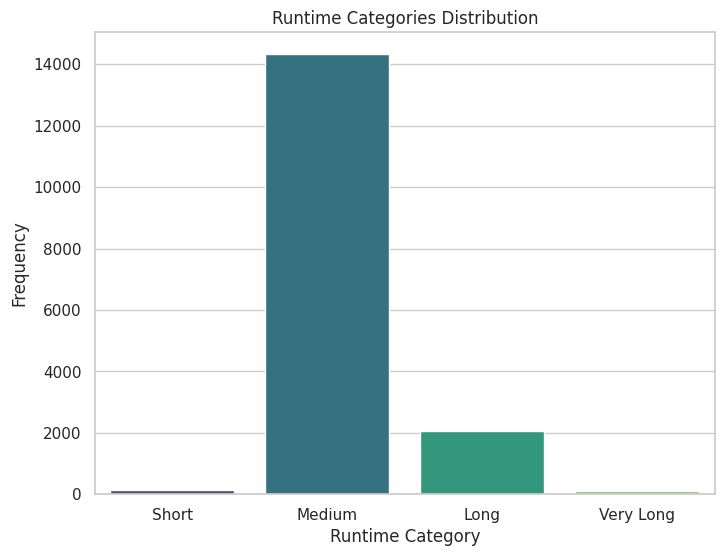

In [ ]:
data['time_to_stream'] = (data['on_streaming_date'] - data['in_theaters_date']).dt.days.clip(lower=0)

data['runtime_category'] = pd.cut(
    data['runtime_in_minutes'],
    bins=[0, 60, 120, 180, 300],
    labels=['Short', 'Medium', 'Long', 'Very Long']
)
data['rating_weighted'] = data['tomatometer_rating'] * data['tomatometer_count']

data['release_month'] = data['in_theaters_date'].dt.month
data['release_year'] = data['in_theaters_date'].dt.year

if 'movie_info' in data.columns:
    data['movie_info_length'] = data['movie_info'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

if 'directors' in data.columns:
    top_directors = data['directors'].value_counts().head(10).index
    data['directors_simplified'] = data['directors'].apply(lambda x: x if x in top_directors else 'Others')

columns_to_drop = ['movie_info', 'critics_consensus', 'directors']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)

categorical_columns = ['rating', 'studio_name']
if 'directors_simplified' in data.columns:
    categorical_columns.append('directors_simplified')

print("New Features Added:")
print(data[['time_to_stream', 'runtime_category', 'rating_weighted',
           'release_month', 'release_year', 'movie_info_length', 'directors_simplified']].head())

plt.figure(figsize=(8, 6))
sns.histplot(data['rating_weighted'], bins=50, kde=True, color='purple')
plt.title("Distribution of Rating Weighted Feature")
plt.xlabel("Rating Weighted")
plt.ylabel("Frequency")
plt.show()

if 'runtime_category' in data.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=data['runtime_category'], palette="viridis")
    plt.title("Runtime Categories Distribution")
    plt.xlabel("Runtime Category")
    plt.ylabel("Frequency")
    plt.show()


Correlation Matrix for Numerical Features

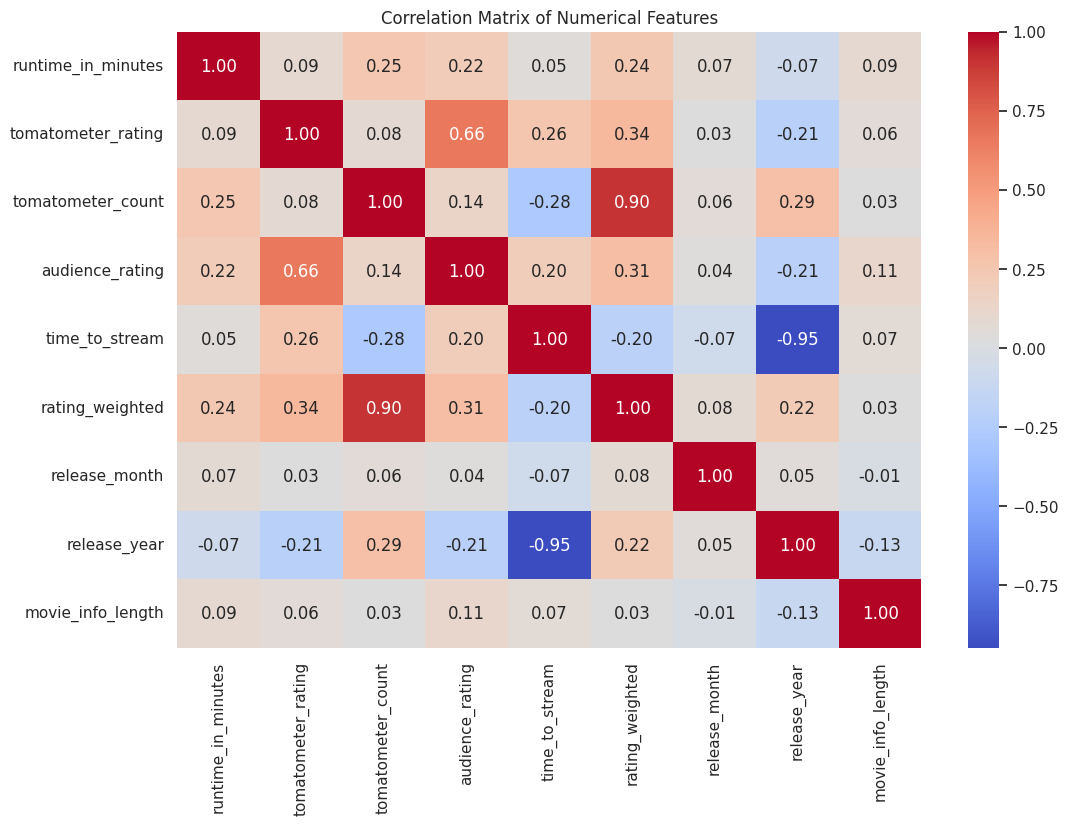

In [ ]:

plt.figure(figsize=(12, 8))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Train-Test Split

In [ ]:

X = data.drop(columns=['audience_rating', 'movie_title', 'in_theaters_date', 'on_streaming_date'])
y = data['audience_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTrain-Test Split Completed:")
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")



Train-Test Split Completed:
Training set: X_train: (13309, 16), y_train: (13309,)
Test set: X_test: (3328, 16), y_test: (3328,)


#  Defining preprocessing pipeline

In [ ]:
categorical_columns = ['rating', 'studio_name']
numerical_columns = ['tomatometer_rating', 'tomatometer_count', 'runtime_in_minutes', 'release_year']

if 'directors_simplified' in data.columns:
    categorical_columns.append('directors_simplified')

available_columns = X.columns
categorical_columns = [col for col in categorical_columns if col in available_columns]
numerical_columns = [col for col in numerical_columns if col in available_columns]

for col in categorical_columns:
    if col in X:
        X[col] = X[col].astype(str)
    if col in X_train and col in X_test:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions={
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    n_iter=10,
    cv=2,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

y_pred_tuned = random_search.best_estimator_.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)

print("\nBest Parameters Found:", random_search.best_params_)
print("Best Cross-Validation R² Score:", random_search.best_score_)
print("\nTuned Model Evaluation Metrics:")
print(f"R² Score: {r2_tuned:.2f}")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.2f}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best Parameters Found: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 10}
Best Cross-Validation R² Score: 0.5247739883336521

Tuned Model Evaluation Metrics:
R² Score: 0.50
Mean Absolute Error (MAE): 11.19
Mean Squared Error (MSE): 201.75


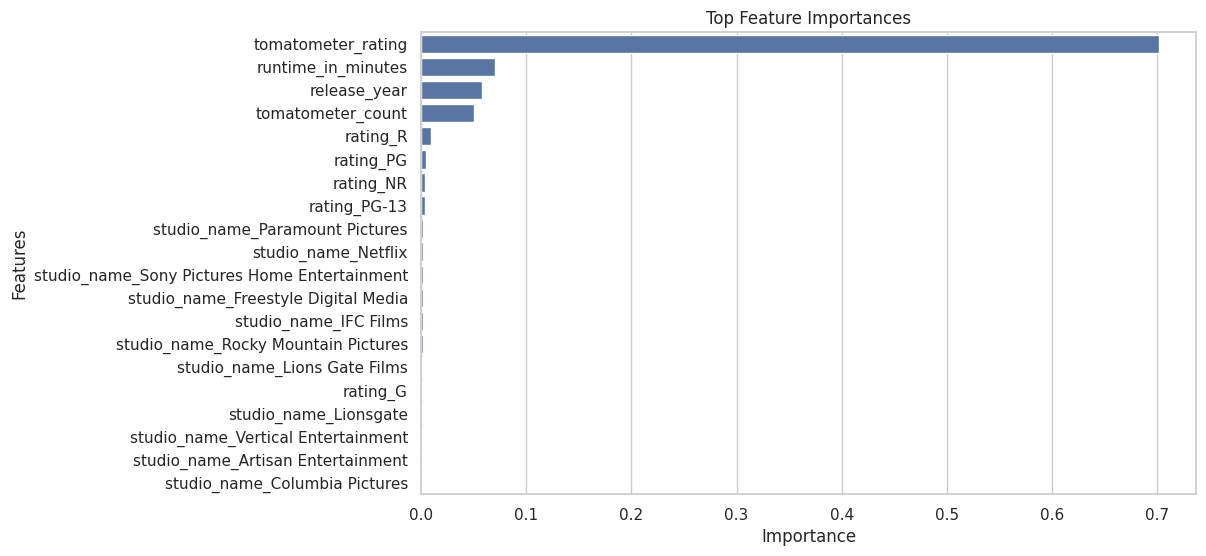

In [ ]:

best_pipeline = random_search.best_estimator_

preprocessor_fitted = best_pipeline.named_steps['preprocessor']
model_fitted = best_pipeline.named_steps['model']

feature_names = []

feature_names.extend(numerical_columns)

ohe_categories = preprocessor_fitted.named_transformers_['cat'].categories_
for col, categories in zip(categorical_columns, ohe_categories):
    feature_names.extend([f"{col}_{cat}" for cat in categories])

importances = model_fitted.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))  # Top 20 features
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


 Calculate residuals

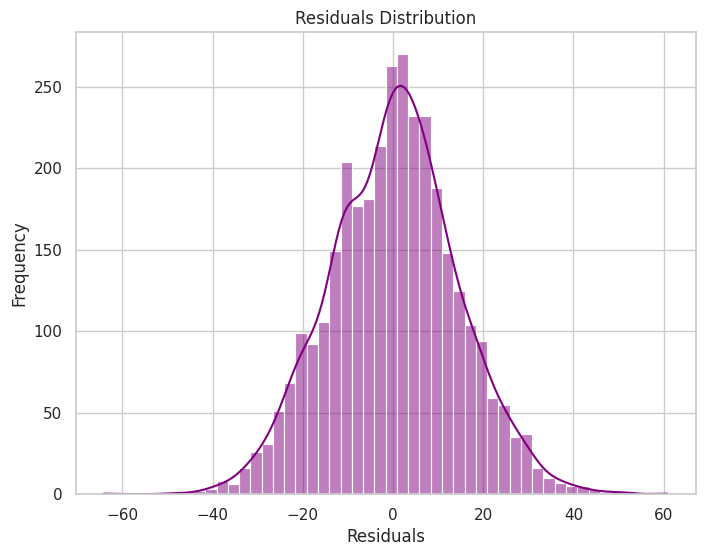

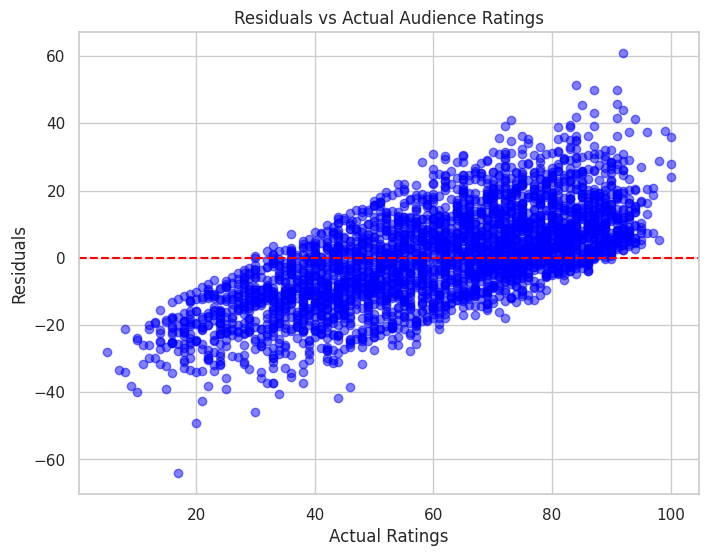

In [ ]:

residuals = y_test - y_pred_tuned

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Audience Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Residuals")
plt.show()


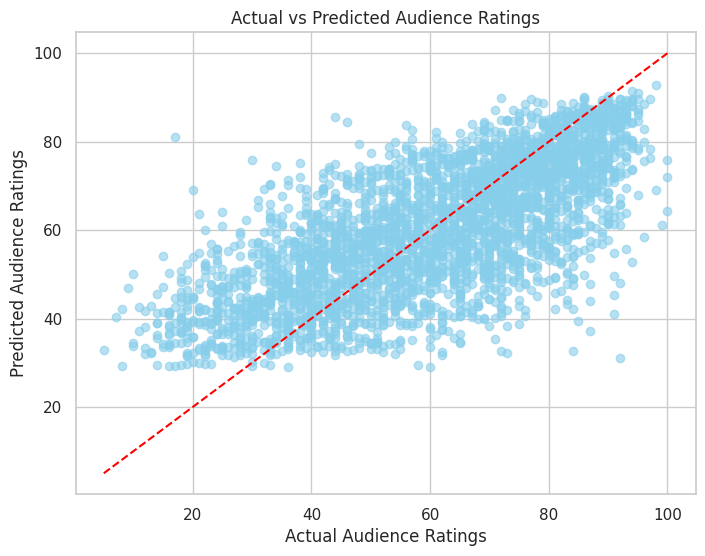

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned, color='skyblue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Audience Ratings")
plt.xlabel("Actual Audience Ratings")
plt.ylabel("Predicted Audience Ratings")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)

print("Cross-Validation R² Scores:", cv_scores)
print(f"Mean R² Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of R² Scores: {cv_scores.std():.2f}")


Cross-Validation R² Scores: [0.55708592 0.51867788 0.50576001 0.52047233 0.52464528]
Mean R² Score: 0.53
Standard Deviation of R² Scores: 0.02


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [20, 31, 50],
    'model__min_data_in_leaf': [10, 20, 30],
    'model__max_depth': [-1, 10, 20]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

y_pred_tuned = random_search.best_estimator_.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)

print("\nBest Parameters Found:", random_search.best_params_)
print("Best Cross-Validation R² Score:", random_search.best_score_)
print("\nTuned Model Evaluation Metrics:")
print(f"R² Score: {r2_tuned:.2f}")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.2f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 13309, number of used features: 128
[LightGBM] [Info] Start training from score 60.455514
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Best Parameters Found: {'model__num_leaves': 20, 'model__n_estimators': 300, 'model__min_data_in_leaf': 20, 'model__max_depth': 20, 'model__learning_rate': 0.05}
Best Cross-Validation R² Score: 0.5415115939016029

Tuned Model Evaluation Metrics:
R² Score: 0.52
Mean Absolute Error (MAE): 10

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


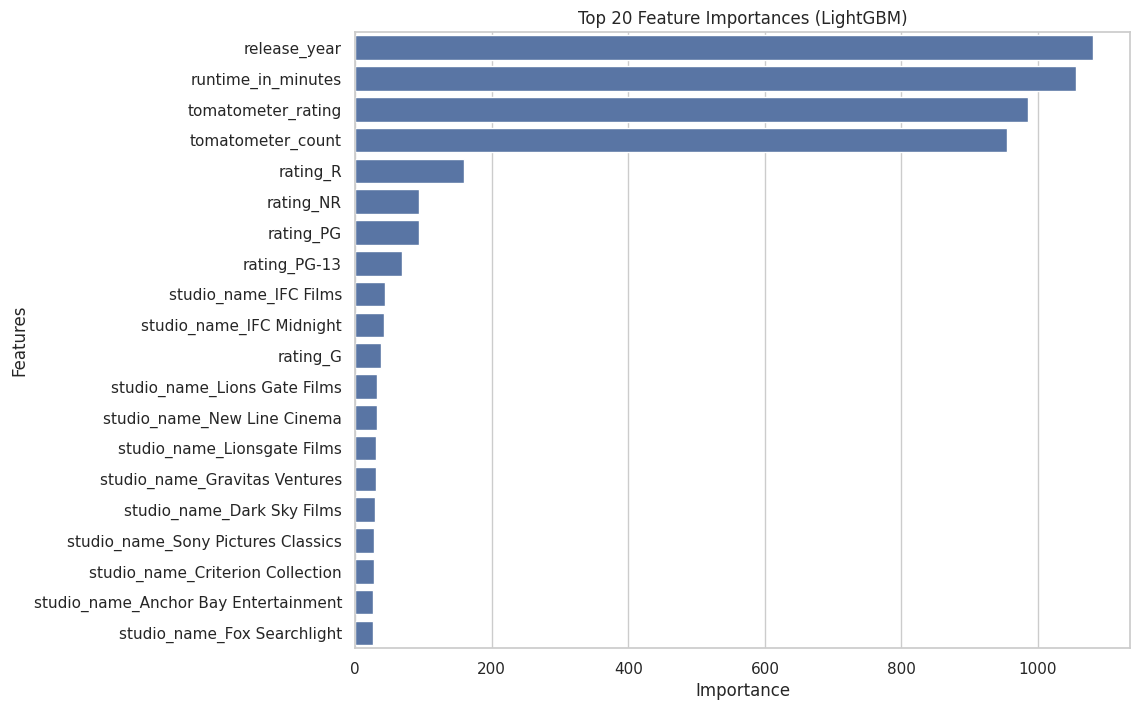

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

best_model = random_search.best_estimator_.named_steps['model']
preprocessor_fitted = random_search.best_estimator_.named_steps['preprocessor']

feature_names = []

feature_names.extend(numerical_columns)
ohe = preprocessor_fitted.transformers_[1][1]
ohe_categories = ohe.categories_
for col, categories in zip(categorical_columns, ohe_categories):
    feature_names.extend([f"{col}_{cat}" for cat in categories])

feature_importances = best_model.feature_importances_

if len(feature_names) != len(feature_importances):
    feature_names = feature_names[:len(feature_importances)]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


In [ ]:

importance_threshold = 0.01

low_importance_features = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature'].tolist()
print(f"Low-Importance Features (Importance < {importance_threshold}):")
print(low_importance_features)

X_reduced = X.drop(columns=low_importance_features, errors='ignore')

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

pipeline_reduced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

random_search_reduced = RandomizedSearchCV(
    pipeline_reduced,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = random_search_reduced.best_estimator_.predict(X_test_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)

print("\nTuned Model Evaluation Metrics (Reduced Features):")
print(f"R² Score: {r2_reduced:.2f}")
print(f"Mean Absolute Error (MAE): {mae_reduced:.2f}")
print(f"Mean Squared Error (MSE): {mse_reduced:.2f}")


Low-Importance Features (Importance < 0.01):
['studio_name_Peach Arch Entertainment', 'studio_name_Paulist Productions', 'studio_name_Peace Arch Entertainment', 'studio_name_PhilGrabsky.com', 'studio_name_Philistine Films', 'studio_name_Paul Devlin Productions', 'studio_name_Peace Arch Films', 'studio_name_Phil Donahue Enterprises', 'studio_name_Petri Entertainment', 'studio_name_Phase 4 Films Inc.', 'studio_name_Lorber Films', 'studio_name_Phaedra Cinema', 'studio_name_Lord Loudoun', 'studio_name_Petit Film', 'studio_name_Perlmutt Productions', 'studio_name_Perdido Productions', 'studio_name_Peach Arch Entertainment/Vitagraph Films', 'studio_name_Pepper and Bones', 'studio_name_Peninsula Films', 'studio_name_Pellicola Films', 'studio_name_Picture Farm', 'studio_name_MCR Releasing', 'studio_name_Picture This! Entertainment', 'studio_name_Polsky Films', 'studio_name_Priority Films/Slowhand Cinema Releasing', 'studio_name_Priority Films', 'studio_name_Prime Entertainment', 'studio_name_P

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 13309, number of used features: 128
[LightGBM] [Info] Start training from score 60.455514
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Tuned Model Evaluation Metrics (Reduced Features):
R² Score: 0.52
Mean Absolute Error (MAE): 10.96
Mean Squared Error (MSE): 195.31


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Calculating Residuals

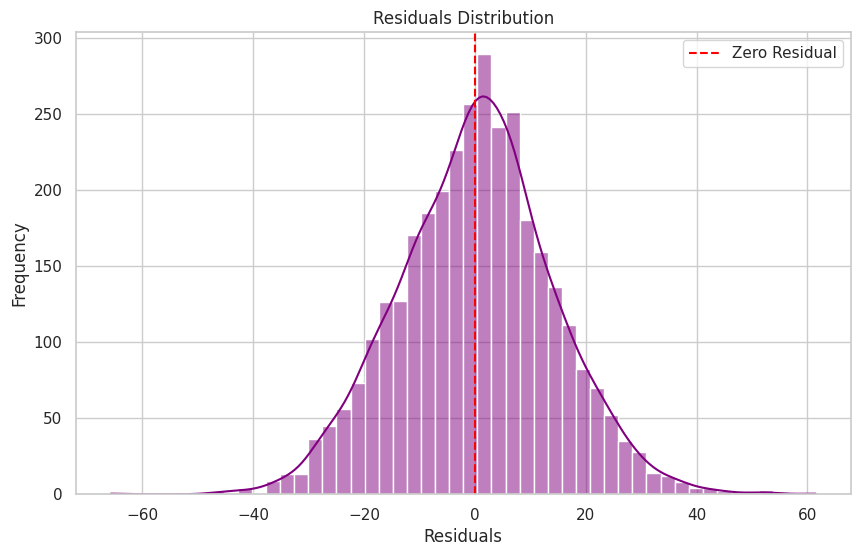

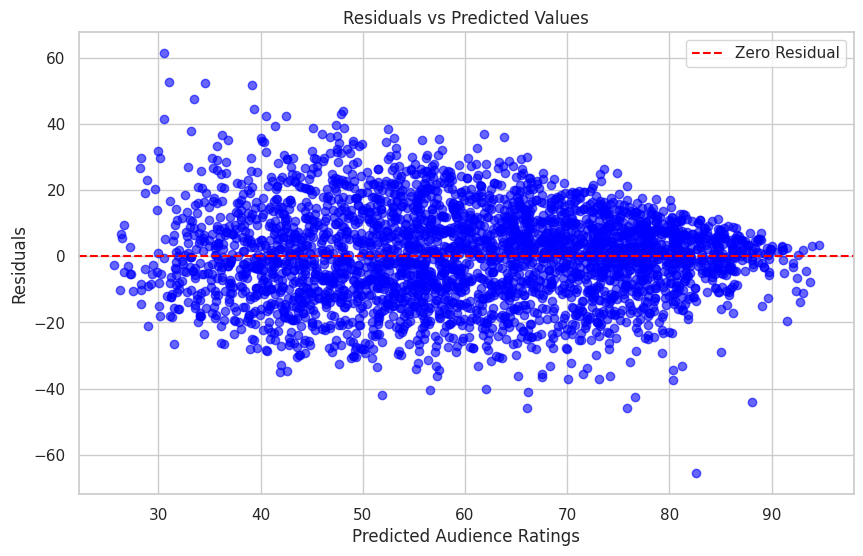

In [ ]:

residuals = y_test - y_pred_tuned

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned, residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Audience Ratings")
plt.ylabel("Residuals")
plt.legend()
plt.show()


In [ ]:

importance_threshold = 0.01
reduced_features = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()

print(f"Number of Features Before Reduction: {len(feature_importance_df)}")
print(f"Number of Features After Reduction: {len(reduced_features)}")

print("\nModel Performance Comparison:")
print("Original Model:")
print(f"R² Score: 0.54 (Previous)")
print("Reduced Features Model:")
print(f"R² Score: {r2_reduced:.2f}")
print(f"Mean Absolute Error (MAE): {mae_reduced:.2f}")
print(f"Mean Squared Error (MSE): {mse_reduced:.2f}")


Number of Features Before Reduction: 2453
Number of Features After Reduction: 94

Model Performance Comparison:
Original Model:
R² Score: 0.54 (Previous)
Reduced Features Model:
R² Score: 0.52
Mean Absolute Error (MAE): 10.96
Mean Squared Error (MSE): 195.31


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_reduced = cross_val_score(random_search_reduced.best_estimator_, X_reduced, y, cv=5, scoring='r2', n_jobs=-1)

print("Cross-Validation R² Scores (Reduced Features):", cv_scores_reduced)
print(f"Mean R² Score: {cv_scores_reduced.mean():.2f}")
print(f"Standard Deviation of R² Scores: {cv_scores_reduced.std():.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross-Validation R² Scores (Reduced Features): [0.57535421 0.53341892 0.51911157 0.54309795 0.53761137]
Mean R² Score: 0.54
Standard Deviation of R² Scores: 0.02


In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
!pip install --upgrade xgboost catboost

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


catboost_param_grid = {
    'model__iterations': [500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5]
}

def train_and_evaluate_model(model_name, model, param_grid):
    print(f"\nTesting {model_name}...\n")

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        scoring='r2',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    try:
        random_search.fit(X_train, y_train)
        y_pred = random_search.best_estimator_.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f"\n{model_name} Results:")
        print(f"Best Parameters: {random_search.best_params_}")
        print(f"R² Score: {r2:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")

    except Exception as e:
        print(f"Error during {model_name} training: {e}")
        print("Please check preprocessing, data format, or hyperparameter grid.")

train_and_evaluate_model("CatBoost", CatBoostRegressor(verbose=0, random_state=42), catboost_param_grid)



Testing CatBoost...

X_train shape: (13309, 16), y_train shape: (13309,)
X_test shape: (3328, 16), y_test shape: (3328,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits

CatBoost Results:
Best Parameters: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 5, 'model__iterations': 1000, 'model__depth': 10}
R² Score: 0.52
Mean Absolute Error (MAE): 10.91
Mean Squared Error (MSE): 193.81
